Let's give some deep learning a shot

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset
import torchvision

In [12]:
### Load data

train_data_1 = np.load('DES_GalGal_Big/CONFIGURATION_1_images.npy')
train_data_2 = np.load('DES_GalGal_Big/CONFIGURATION_2_images.npy')

train_data = np.vstack((train_data_1, train_data_2)) #/ np.max((np.max(train_data_1), np.max(train_data_2)))
train_labels = np.array([1] * len(train_data_1) + [0] * len(train_data_2))

test_data_1 = np.load('DES_GalGal_Big/CONFIGURATION_3_images.npy')
test_data_2 = np.load('DES_GalGal_Big/CONFIGURATION_4_images.npy')

test_data = np.vstack((test_data_1, test_data_2)) #/ np.max((np.max(test_data_1), np.max(test_data_2)))
test_labels = np.array([1] * len(test_data_1) + [0] * len(test_data_2))

del train_data_1, train_data_2, test_data_1, test_data_2

In [13]:
### Make a PyTorch Dataset Object

class DeepLenstronomyDataset(Dataset):
    """Dataset of DeepLenstronomy Images"""

    def __init__(self, images, labels, transform=None):
        """
        docstring
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.images[idx]
        label = np.array(self.labels[idx])
        
        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        
        #RM : My images are already C x H x W :P
        
        #image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image).float(),
                'label': torch.from_numpy(label)}

In [14]:
train_dataset = DeepLenstronomyDataset(train_data, train_labels, transform=ToTensor())
test_dataset = DeepLenstronomyDataset(test_data, test_labels, transform=ToTensor())

In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=50, shuffle=True, num_workers=4)

In [16]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        #Network Components
        self.conv1 = nn.Conv2d(in_channels=5, 
                               out_channels=32, 
                               kernel_size=5, 
                               stride=1,
                               padding=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, 
                               out_channels=64,
                               kernel_size=3, 
                               stride=1,
                               padding=2)
        
        self.dropout1 = nn.Dropout2d(0.25)
        
        self.dropout2 = nn.Dropout2d(0.5)
        
        self.fc1 = nn.Linear(in_features=166464, 
                             out_features=408)
        
        self.fc2 = nn.Linear(in_features=408, 
                             out_features=16)
        
        self.fc3 = nn.Linear(in_features=16, 
                             out_features=2)
        
    def forward(self, x):
        #Network Flow
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

cnn = CNN()
print(cnn)

CNN(
  (conv1): Conv2d(5, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (dropout1): Dropout2d(p=0.25)
  (dropout2): Dropout2d(p=0.5)
  (fc1): Linear(in_features=166464, out_features=408, bias=True)
  (fc2): Linear(in_features=408, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)


In [17]:
number_of_training_epochs = 4
validation_size = 200
loss_function = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

In [18]:
losses, train_acc, validation_acc = [], [], []

for epoch in range(number_of_training_epochs):
    
    for i_batch, sample_batched in enumerate(train_dataloader):
        
        #Clear out all existing gradients on the loss surface to reevaluate for this step
        optimizer.zero_grad()
        
        #Get the CNN's current prediction of the training data
        output = cnn(sample_batched['image'])
        
        #Calculate the loss by comparing the prediction to the truth
        loss = loss_function(output, sample_batched['label']) 
        
        #Evaluate all gradients along the loss surface using back propagation
        loss.backward()
        
        #Based on the gradients, take the optimal step in the weight space
        optimizer.step()
        
        #Performance monitoring
        if i_batch % 50 == 0:
            train_output = cnn(train_dataset[0:validation_size]['image'])
            validation_output = cnn(test_dataset[0:validation_size]['image'])
        
            train_predictions = torch.max(train_output, 1)[1].data.numpy()
            validation_predictions = torch.max(validation_output, 1)[1].data.numpy()

            train_accuracy = np.sum(train_predictions == train_dataset[0:validation_size]['label'].numpy()) / validation_size
            validation_accuracy = np.sum(validation_predictions == test_dataset[0:validation_size]['label'].numpy()) / validation_size
            
            print("Epoch: {0} Batch: {1}  | Training Accuracy: {2} -- Validation Accuracy: {3}".format(epoch + 1, i_batch + 1, train_accuracy, validation_accuracy))

            losses.append(loss.data.numpy())
            train_acc.append(train_accuracy)
            validation_acc.append(validation_accuracy)


Epoch: 1 Batch: 1  | Training Accuracy: 0.985 -- Validation Accuracy: 0.985
Epoch: 1 Batch: 51  | Training Accuracy: 0.69 -- Validation Accuracy: 0.645
Epoch: 1 Batch: 101  | Training Accuracy: 0.705 -- Validation Accuracy: 0.675
Epoch: 1 Batch: 151  | Training Accuracy: 0.655 -- Validation Accuracy: 0.66
Epoch: 2 Batch: 1  | Training Accuracy: 0.75 -- Validation Accuracy: 0.755
Epoch: 2 Batch: 51  | Training Accuracy: 0.86 -- Validation Accuracy: 0.87
Epoch: 2 Batch: 101  | Training Accuracy: 0.875 -- Validation Accuracy: 0.87
Epoch: 2 Batch: 151  | Training Accuracy: 0.81 -- Validation Accuracy: 0.84
Epoch: 3 Batch: 1  | Training Accuracy: 0.82 -- Validation Accuracy: 0.86
Epoch: 3 Batch: 51  | Training Accuracy: 0.89 -- Validation Accuracy: 0.885
Epoch: 3 Batch: 101  | Training Accuracy: 0.865 -- Validation Accuracy: 0.9
Epoch: 3 Batch: 151  | Training Accuracy: 0.925 -- Validation Accuracy: 0.93
Epoch: 4 Batch: 1  | Training Accuracy: 0.97 -- Validation Accuracy: 0.96
Epoch: 4 Batc

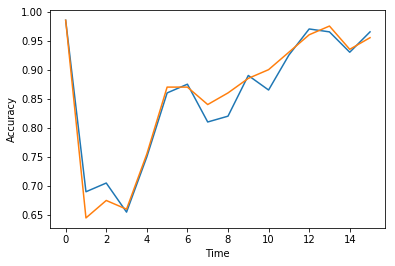

In [20]:
plt.figure()
plt.plot(np.arange(len(train_acc)), train_acc, label="Training")
plt.plot(np.arange(len(validation_acc)), validation_acc, label="Validation")
plt.xlabel("Time")
plt.ylabel("Accuracy")
plt.show()

1


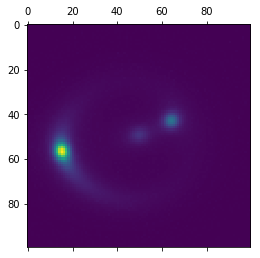

In [23]:
print(train_labels[0])
plt.matshow(train_data[0][0])

0


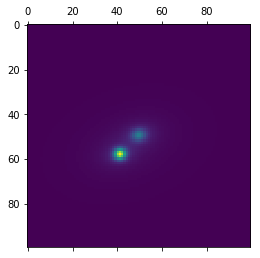

In [24]:
print(train_labels[-1])
plt.matshow(train_data[-1][0])

In [25]:
def plot_and_label(ax, im, label):
    ax.matshow(im)
    ax.set_title(str(label))
    return ax

In [ ]:
fig, axs = plt.subplots(2, 5)

for i in [0, 1, 2, 3, 4]:
    plot_and_label(axs[0])